# AH2179 Applied Artificial Intelligence in Transportation Group 5 Project
### By Fabian Fermazin, William Öman, Itsuki Shindo

In [ ]:
pip install calmap

In [4]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
#import calmap

In [ ]:
df = pd.read_csv('Dataset-PT_seasons.csv')
Stockholmtemp2022 = pd.read_csv('Stockholmtemp2022.csv', sep=';')

#Adding Temp Data

In [ ]:
# Change the date format of Stockholmtemp2022 to match the df
def change_date_format(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime("%Y%m%d")
Stockholmtemp2022["date"] = Stockholmtemp2022["date"].apply(change_date_format)

# Change the name of the date column to match the df
Stockholmtemp2022["Calendar_date"] = 0
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["date"]
Stockholmtemp2022.drop(columns=["date"])

,temp,Calendar_date
0,-1.4,20220101
1,1.9,20220102
2,3.6,20220103
3,0.6,20220104
4,-2.2,20220105
...,...,...
176,23.1,20220626
177,24.1,20220627
178,24.1,20220628
179,19.6,20220629


In [ ]:
# Merge df and Stockholmtemp2022
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["Calendar_date"].astype(int)
df = pd.merge(df, Stockholmtemp2022, on='Calendar_date')
df.drop(columns=['date'])
df["Calendar_date"] = pd.to_datetime(df['Calendar_date'], format='%Y%m%d')

#Data visualisation, etc

In [ ]:
# Correlations between arrival delay and other variables
corr_matrix = df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)

<ipython-input-46-536349da8134>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


arrival_delay                        1.000000
upstream_stop_delay                  0.975019
origin_delay                         0.716324
previous_bus_delay                   0.265434
factor(day_of_week)weekend           0.190783
factor(time_of_day)Off-peak          0.138109
temp                                 0.108624
stop_sequence                        0.092616
dwell_time                           0.089433
travel_time_for_previous_section     0.081113
factor(weather)Normal                0.022642
factor(temperature)Normal            0.022444
factor(weather)Rain                  0.010833
factor(weather)Snow                 -0.001579
factor(weather)Light_Snow           -0.012642
bus_id                              -0.012769
factor(temperature)Cold             -0.013595
factor(temperature)Extra_cold       -0.024602
factor(weather)Light_Rain           -0.027323
previous_trip_travel_time           -0.036870
traffic_condition                   -0.043104
recurrent_delay                   

<ipython-input-47-e9cb4a2e9e5e>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = x.corr()


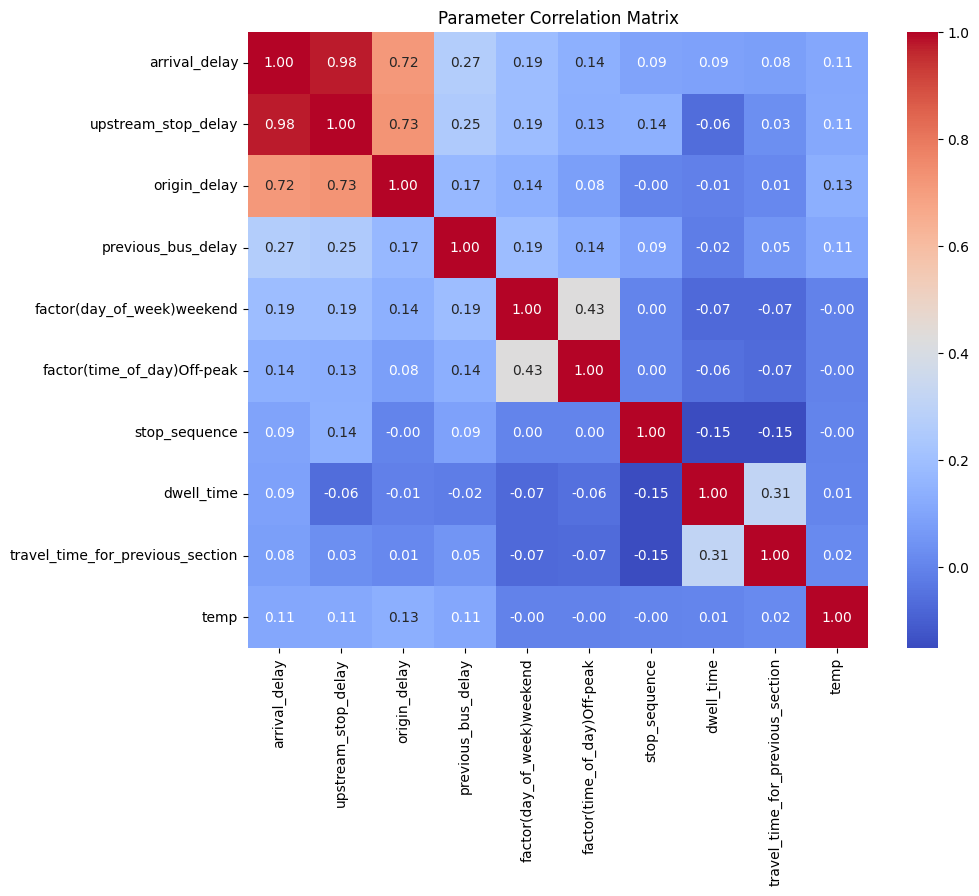

In [ ]:
x = df[['arrival_delay', 'upstream_stop_delay', 'origin_delay', 'previous_bus_delay',
        'factor(day_of_week)weekend', 'factor(time_of_day)Off-peak', 'Calendar_date',
        'stop_sequence', 'dwell_time','travel_time_for_previous_section', 'temp']]

# Calculate the correlation matrix
correlation_matrix = x.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Parameter Correlation Matrix')
plt.show()

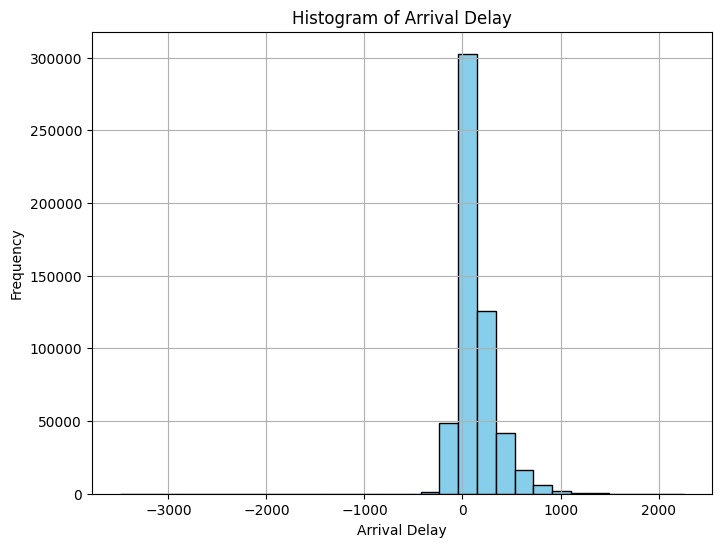

In [ ]:
# Distribution of arrival delays
plt.figure(figsize=(8, 6))
plt.hist(df['arrival_delay'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Arrival Delay')
plt.xlabel('Arrival Delay')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Note to self: 594 rows in the first day, which corresponds to 22 trips in a day, if there are 27 stops.


June 30th and May 25th have some strange busses which have -1 hour or -30 minutes delay

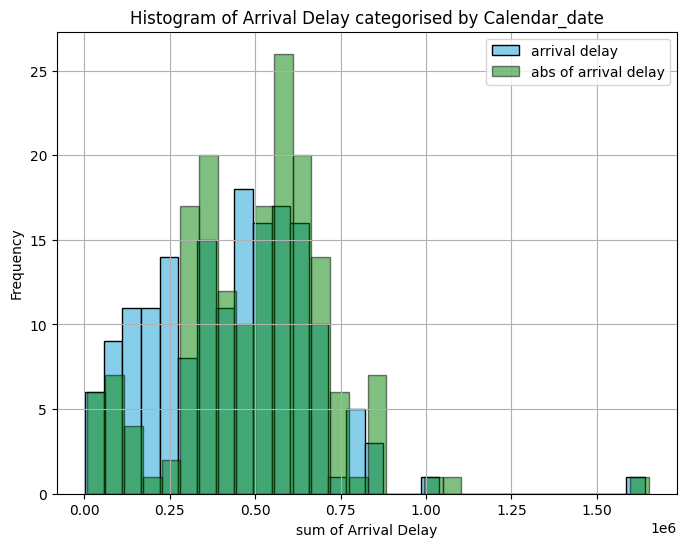

In [ ]:

df['arrival_delay_abs'] = df['arrival_delay'].abs()

Calendar_date_delay = df.groupby('Calendar_date')['arrival_delay'].sum()
Calendar_date_delay_abs = df.groupby('Calendar_date')['arrival_delay_abs'].sum()


plt.figure(figsize=(8, 6))
plt.hist(Calendar_date_delay, bins=30, color='skyblue', edgecolor='black', label ='arrival delay')
plt.hist(Calendar_date_delay_abs, bins=30, color='green', edgecolor='black', alpha = 0.5, label ='abs of arrival delay')

plt.legend()
plt.title('Histogram of Arrival Delay categorised by Calendar_date')
plt.xlabel('sum of Arrival Delay')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

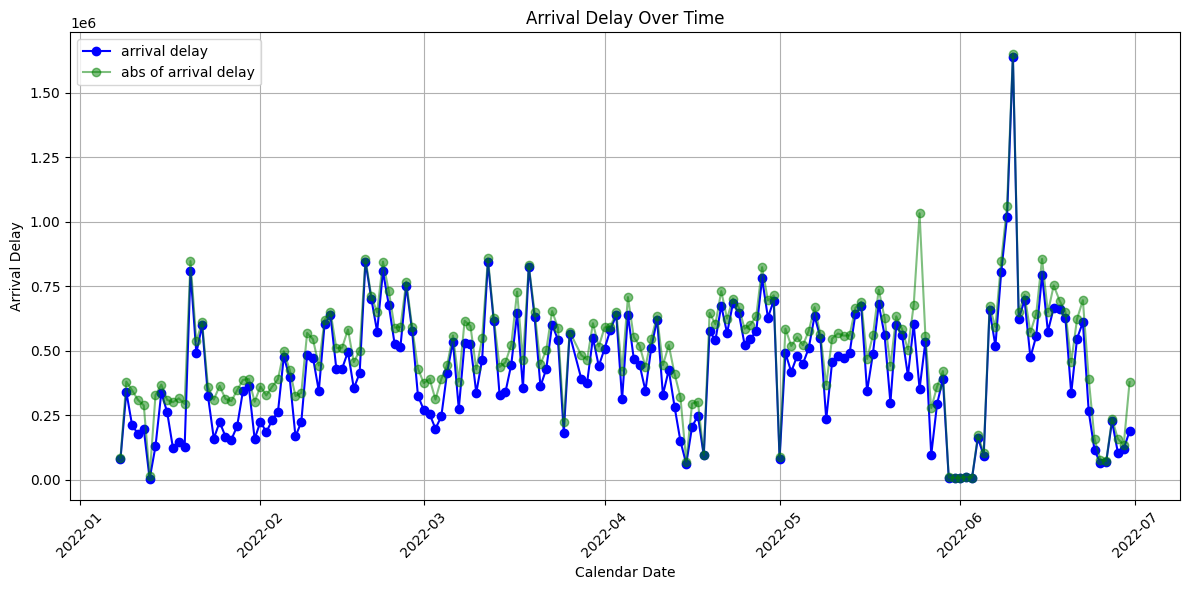

In [ ]:
# Comparing arrival delay with abs value of arrival delay troughout time
# Convert the index (Calendar_date) to datetime
Calendar_date_delay.index = pd.to_datetime(Calendar_date_delay.index)
Calendar_date_delay_abs.index = pd.to_datetime(Calendar_date_delay_abs.index)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(Calendar_date_delay.index, Calendar_date_delay.values, marker='o', linestyle='-', color='b', label ='arrival delay')
plt.plot(Calendar_date_delay_abs.index, Calendar_date_delay_abs.values, marker='o', linestyle='-', color='g', alpha = 0.5, label ='abs of arrival delay')

plt.legend()

plt.title('Arrival Delay Over Time')
plt.xlabel('Calendar Date')
plt.ylabel('Arrival Delay')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-a*xis labels for readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

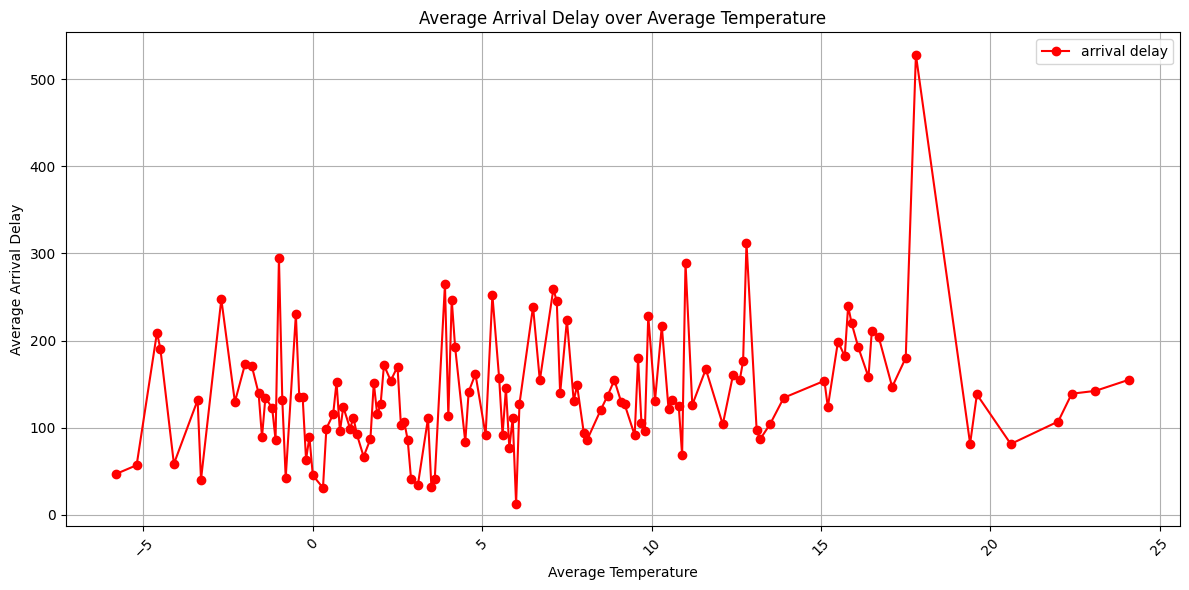

In [ ]:

Temp_delay = df.groupby('temp')['arrival_delay'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(Temp_delay.index, Temp_delay, marker='o', linestyle='-', color='r', label ='arrival delay')

plt.legend()

plt.title('Average Arrival Delay over Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Average Arrival Delay')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-a*xis labels for readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

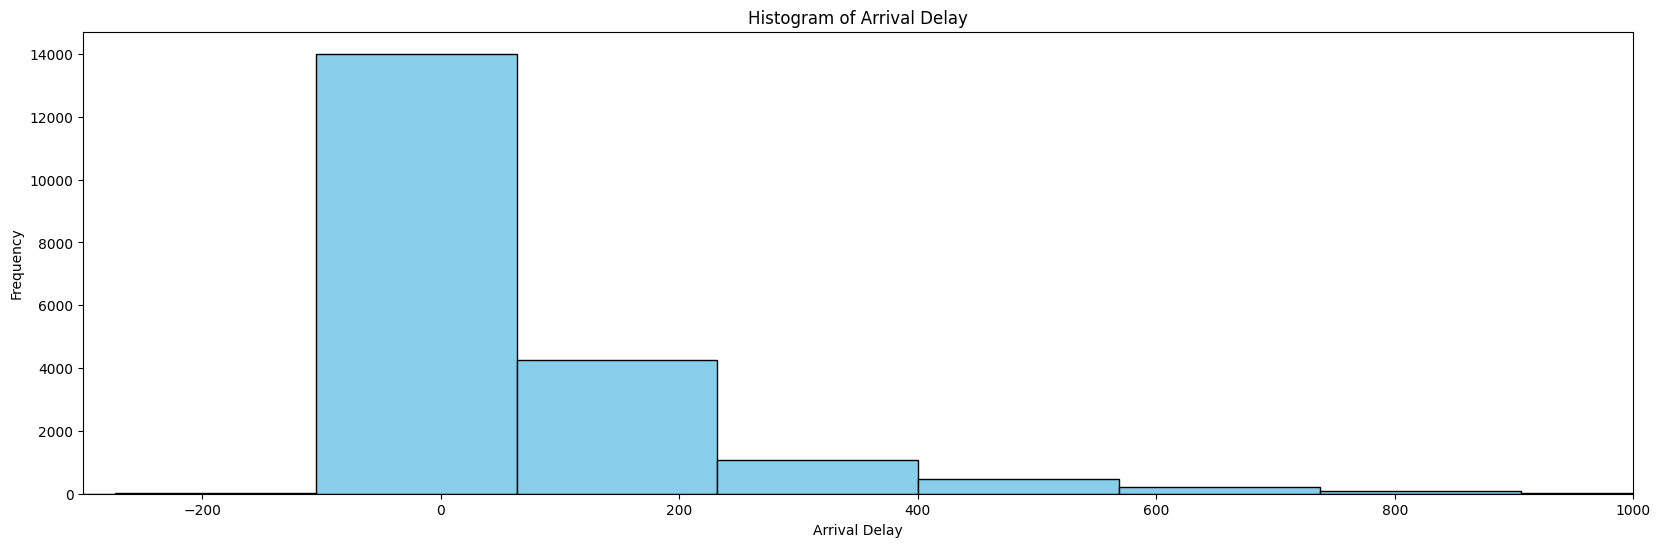

In [ ]:
filtered_df = df[df['stop_sequence'] == 1]

plt.figure(figsize=(20, 6))
plt.hist(filtered_df['arrival_delay'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Arrival Delay at stop 1')
plt.xlabel('Arrival Delay')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-300,1000)
plt.show()

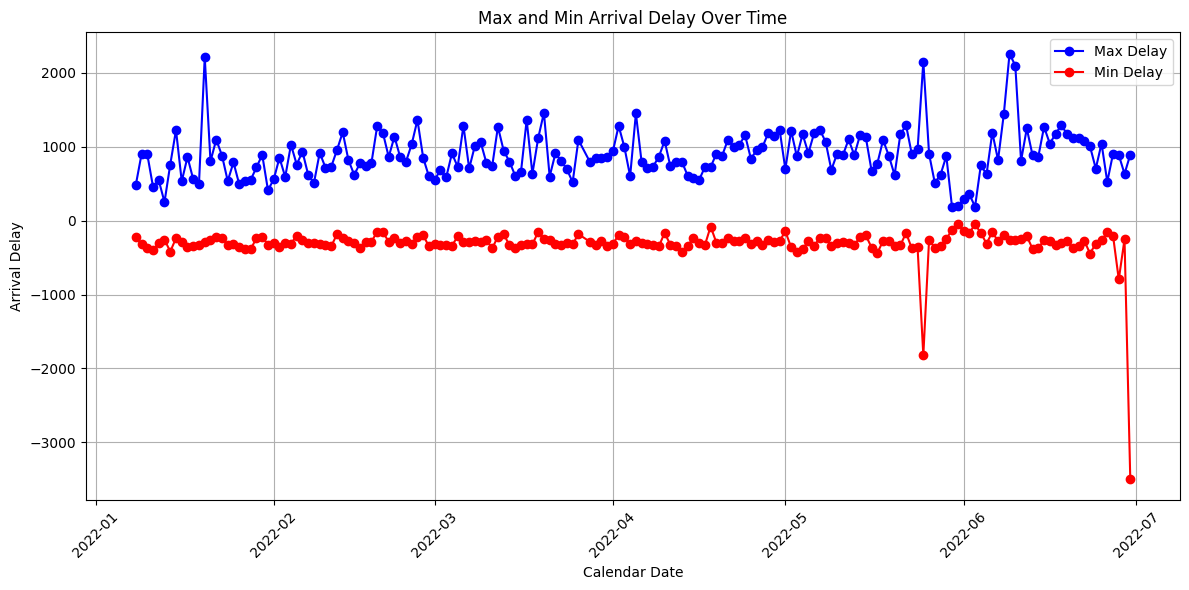

In [ ]:
# Comparing min and max delay to see if the very early busses are compensating for very delayed busses or if its and outlier
# Group the data by 'Calendar_date' and calculate max and min values
grouped = df.groupby('Calendar_date')['arrival_delay'].agg(['max', 'min']).reset_index()

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(grouped['Calendar_date'], grouped['max'], marker='o', linestyle='-', color='b', label='Max Delay')
plt.plot(grouped['Calendar_date'], grouped['min'], marker='o', linestyle='-', color='r', label='Min Delay')

# Add a legend
plt.legend(loc='upper right')

plt.title('Max and Min Arrival Delay Over Time')
plt.xlabel('Calendar Date')
plt.ylabel('Arrival Delay')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dropping the bus that is an hour early on the 30th of June, as it seemingly does nto compansate for a large delay

In [ ]:
df_new = df[(df['Calendar_date'] != '2022-06-30') | (df['bus_id'] != 41361)]

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,Season,date,temp,arrival_delay_abs
0,2022-01-08,4,41344,1,151,0,0,120,100,100,...,1,0,1,0,0,1,Winter,20220108,-0.5,151
1,2022-01-08,4,41344,2,185,24,171,45,151,100,...,1,0,1,0,0,1,Winter,20220108,-0.5,185
2,2022-01-08,4,41344,3,186,0,55,41,185,100,...,1,0,1,0,0,1,Winter,20220108,-0.5,186
3,2022-01-08,4,41344,4,202,12,42,94,186,100,...,1,0,1,0,0,1,Winter,20220108,-0.5,202
4,2022-01-08,4,41344,5,242,21,98,86,202,100,...,1,0,1,0,0,1,Winter,20220108,-0.5,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,2022-06-30,4,41362,23,344,13,74,44,341,12,...,1,1,0,0,0,1,Summer,20220630,22.4,344
545099,2022-06-30,4,41362,24,330,15,34,92,344,12,...,1,1,0,0,0,1,Summer,20220630,22.4,330
545100,2022-06-30,4,41362,25,339,17,63,43,330,12,...,1,1,0,0,0,1,Summer,20220630,22.4,339
545101,2022-06-30,4,41362,26,331,0,35,58,339,12,...,1,1,0,0,0,1,Summer,20220630,22.4,331


# Model building, etc

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/MyDrive/AIprojectfiles/clean_dataPT2.csv')

Mounted at /content/drive/


In [4]:
df = pd.read_csv('clean_dataPT2.csv')
df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "date"], axis=1)
df

,Calendar_date,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,...,factor(weather)Rain,factor(weather)Snow,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,Season,temp,trip_id
0,2022-01-08,41344,1,151,0,0,120,100,100,160,...,0,0,0,1,0,0,1,Winter,-0.5,1
1,2022-01-08,41344,2,185,24,171,45,151,100,198,...,0,0,0,1,0,0,1,Winter,-0.5,1
2,2022-01-08,41344,3,186,0,55,41,185,100,189,...,0,0,0,1,0,0,1,Winter,-0.5,1
3,2022-01-08,41344,4,202,12,42,94,186,100,200,...,0,0,0,1,0,0,1,Winter,-0.5,1
4,2022-01-08,41344,5,242,21,98,86,202,100,256,...,0,0,0,1,0,0,1,Winter,-0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545071,2022-06-30,41362,23,344,13,74,44,341,12,47,...,0,0,1,0,0,0,1,Summer,22.4,20189
545072,2022-06-30,41362,24,330,15,34,92,344,12,68,...,0,0,1,0,0,0,1,Summer,22.4,20189
545073,2022-06-30,41362,25,339,17,63,43,330,12,69,...,0,0,1,0,0,0,1,Summer,22.4,20189
545074,2022-06-30,41362,26,331,0,35,58,339,12,79,...,0,0,1,0,0,0,1,Summer,22.4,20189


In [7]:
# Finding a unique key value of the bus data
df.groupby(['Calendar_date', 'bus_id', 'stop_sequence'])['dwell_time'].count().sort_values(ascending=False)

Calendar_date  bus_id  stop_sequence
2022-02-13     41348   20               11
2022-05-15     41344   4                11
                       16               11
                       15               11
                       14               11
                                        ..
2022-06-07     44076   20                1
                       19                1
                       18                1
                       17                1
2022-06-30     45722   27                1
Name: dwell_time, Length: 111024, dtype: int64

In [59]:
df_test = df.groupby(['trip_id'])[['arrival_delay', 'dwell_time',
                                   'traffic_condition', 'recurrent_delay',
                                   'origin_delay', 'previous_bus_delay',
                                   'factor(day_of_week)weekday',
                                   'factor(time_of_day)Off-peak', 'temp']].mean()
df_test

,arrival_delay,dwell_time,traffic_condition,recurrent_delay,origin_delay,previous_bus_delay,factor(day_of_week)weekday,factor(time_of_day)Off-peak,temp
trip_id,,,,,,,,,
1,340.000000,14.037037,65.234568,60.203704,100.0,188.296296,0.0,1.0,-0.5
2,149.222222,9.000000,69.061728,62.318519,17.0,340.000000,0.0,1.0,-0.5
3,86.111111,19.259259,69.691358,64.018519,10.0,149.222222,0.0,1.0,-0.5
4,27.037037,13.888889,67.049383,63.137566,12.0,85.518519,0.0,1.0,-0.5
5,221.296296,18.962963,63.617284,59.898148,3.0,-0.296296,0.0,1.0,-0.5
...,...,...,...,...,...,...,...,...,...
20185,112.555556,25.592593,72.938272,65.666099,17.0,185.074074,1.0,1.0,22.4
20186,151.851852,34.629630,72.407407,65.674356,20.0,107.296296,1.0,1.0,22.4
20187,179.592593,26.333333,67.456790,65.662792,21.0,151.851852,1.0,1.0,22.4


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [60]:
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(df_test)
Scaled_data=scaling.transform(df_test)

# Set the n_components=3
principal=PCA(n_components=2)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x.shape)

(20188, 2)


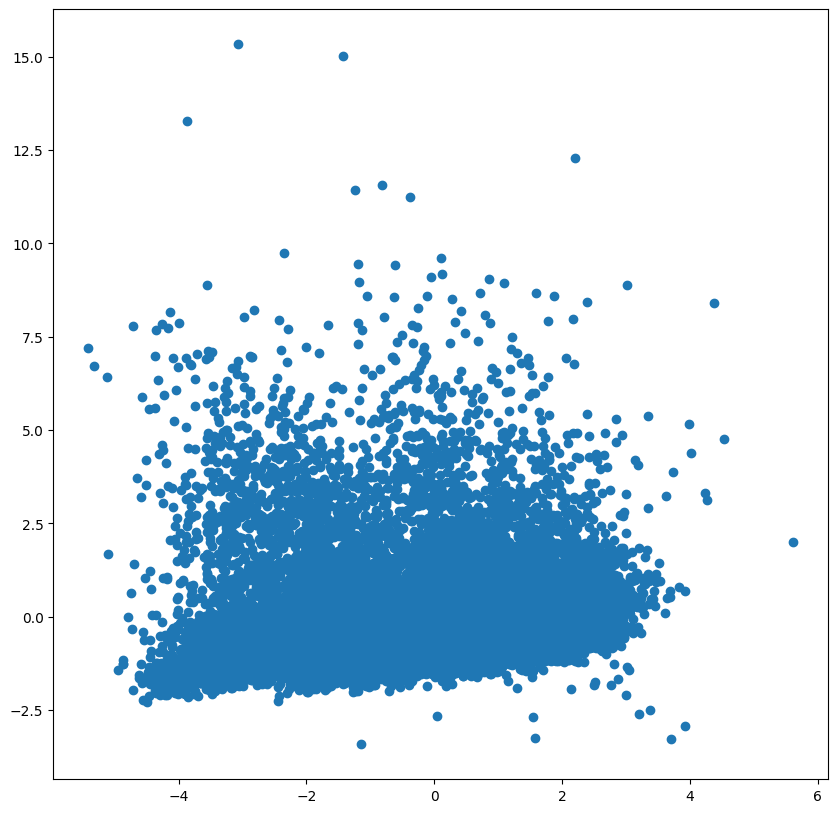

In [61]:
plt.figure(figsize=(10,10))
#plt.xlim(-2.5,0)
#plt.ylim(-2,1)
plt.scatter(x[:,0],x[:,1])

In [62]:
x

array([[-4.25598008, -0.14444125],
       [-3.9560659 , -0.94691599],
       [-2.92778019, -1.26238817],
       ...,
       [-1.59164397, -0.01051854],
       [-1.73883626, -0.35568009],
       [-1.50179583,  0.05649703]])

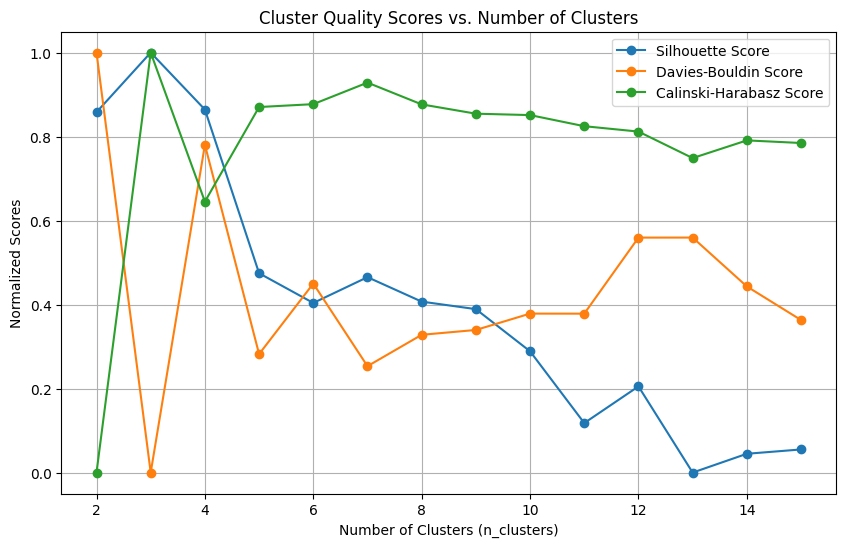

In [63]:
# Define a list of n_clusters values to iterate over
n_clusters_values = list(range(2,16))

# Initialize lists to store scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Loop over different values of n_clusters
for n_clusters in n_clusters_values:
    # Fit K-Means clustering with the current number of clusters
    clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(x)
    cluster_labels = clusters.labels_

    # Calculate cluster quality scores
    SC_score = silhouette_score(x, cluster_labels)
    DB_score = davies_bouldin_score(x, cluster_labels)
    CH_score = calinski_harabasz_score(x, cluster_labels)

    # Append scores to the respective lists
    silhouette_scores.append(SC_score)
    davies_bouldin_scores.append(DB_score)
    calinski_harabasz_scores.append(CH_score)

# Normalize the scores between 0 and 1 (optional)
scaler = MinMaxScaler()
silhouette_scores_normalized = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1))
davies_bouldin_scores_normalized = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1))
calinski_harabasz_scores_normalized = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1))

# Create a DataFrame to store the normalized scores
normalized_scores_df = pd.DataFrame({
    'n_clusters': n_clusters_values,
    'Silhouette Score': silhouette_scores_normalized.flatten(),
    'Davies-Bouldin Score': davies_bouldin_scores_normalized.flatten(),
    'Calinski-Harabasz Score': calinski_harabasz_scores_normalized.flatten()
})

# Plot the scores for each n_clusters value
plt.figure(figsize=(10, 6))
plt.plot(normalized_scores_df['n_clusters'], normalized_scores_df['Silhouette Score'], label='Silhouette Score', marker='o')
plt.plot(normalized_scores_df['n_clusters'], normalized_scores_df['Davies-Bouldin Score'], label='Davies-Bouldin Score', marker='o')
plt.plot(normalized_scores_df['n_clusters'], normalized_scores_df['Calinski-Harabasz Score'], label='Calinski-Harabasz Score', marker='o')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Normalized Scores')
plt.title('Cluster Quality Scores vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

Seven clusters looks like the best option

In [69]:
n_clusters = 7

clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(x) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

if clusters is not None:
  cluster_labels = clusters.labels_

print(cluster_labels)

[3 3 3 ... 5 5 5]


In [70]:
# Calculate the Silhouette Score
SC_score = silhouette_score(x, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(x, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(x, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

Silhouette Score: 0.4002798557277939
Davies-Bouldin Score: 0.8214276824954807
Calinski-Harabasz Score: 17632.921256757087


In [72]:
new_x = np.zeros([len(x), 3])
for i in range(0, len(x)):
    new_x[i] = (np.append(x[i], (cluster_labels[i])))

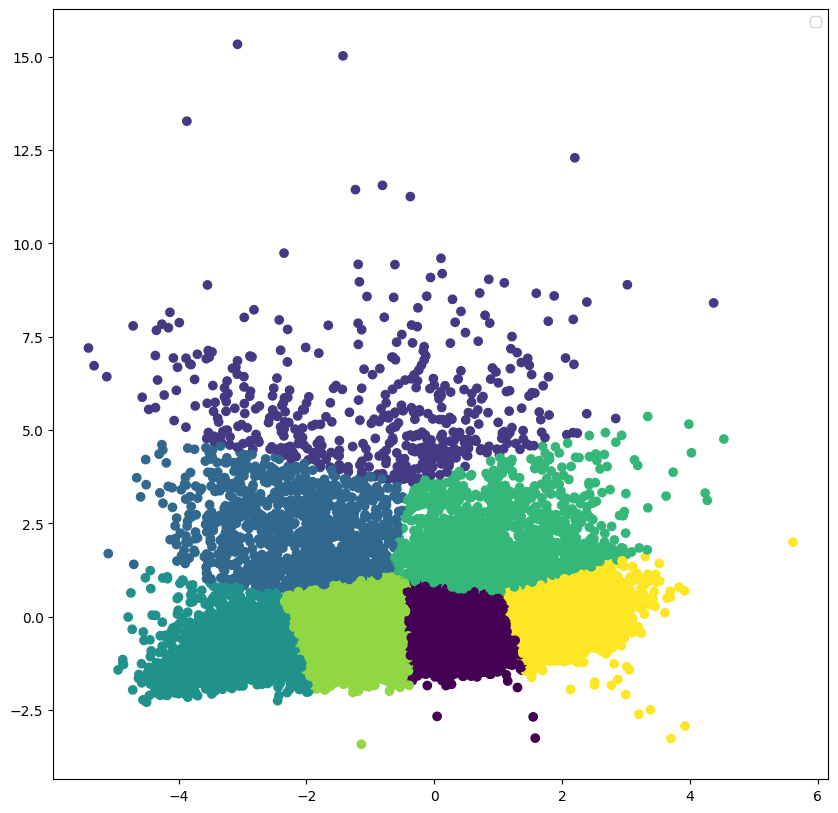

In [73]:
plt.figure(figsize=(10,10))
plt.scatter(new_x[:,0],new_x[:,1], c=new_x[:,2])
plt.legend()

In [74]:
transformed_back_1 = principal.inverse_transform(x)
transformed_back_1

array([[ 0.41310868, -1.6068811 , -1.93331604, ..., -1.82469478,
         1.65805332, -0.00679452],
       [-0.12360723, -1.60602628, -1.98946791, ..., -1.64464007,
         1.53153692, -0.1983698 ],
       [-0.4422689 , -1.26624044, -1.60530817, ..., -1.18158507,
         1.12676388, -0.27953112],
       ...,
       [ 0.18166449, -0.59492314, -0.71271995, ..., -0.68515124,
         0.62059376,  0.00773918],
       [-0.01652487, -0.69753775, -0.86011548, ..., -0.7267131 ,
         0.67388731, -0.07288713],
       [ 0.21289834, -0.55215444, -0.65676205, ..., -0.65068144,
         0.58635211,  0.02299974]])

In [75]:
reversed_df = pd.DataFrame(transformed_back_1)
df_test['Cluster'] = cluster_labels
df_test

,arrival_delay,dwell_time,traffic_condition,recurrent_delay,origin_delay,previous_bus_delay,factor(day_of_week)weekday,factor(time_of_day)Off-peak,temp,Cluster
trip_id,,,,,,,,,,
1,340.000000,14.037037,65.234568,60.203704,100.0,188.296296,0.0,1.0,-0.5,3
2,149.222222,9.000000,69.061728,62.318519,17.0,340.000000,0.0,1.0,-0.5,3
3,86.111111,19.259259,69.691358,64.018519,10.0,149.222222,0.0,1.0,-0.5,3
4,27.037037,13.888889,67.049383,63.137566,12.0,85.518519,0.0,1.0,-0.5,3
5,221.296296,18.962963,63.617284,59.898148,3.0,-0.296296,0.0,1.0,-0.5,3
...,...,...,...,...,...,...,...,...,...,...
20185,112.555556,25.592593,72.938272,65.666099,17.0,185.074074,1.0,1.0,22.4,5
20186,151.851852,34.629630,72.407407,65.674356,20.0,107.296296,1.0,1.0,22.4,5
20187,179.592593,26.333333,67.456790,65.662792,21.0,151.851852,1.0,1.0,22.4,5


In [76]:
import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
color_ramp = get_colors(10)
color_ramp
['#01218c',
 '#05359e',
 '#03c8bf',
 '#4f0e3e',
 '#52fd31',
 '#0daba4',
 '#e1bb99',
 '#5df771',
 '#d6d321',
 '#a8ba9b']
def assign_color(row):
    return color_ramp[row]
df_test['color'] = df_test['Cluster'].map(assign_color)

<Axes: xlabel='factor(day_of_week)weekday', ylabel='arrival_delay'>

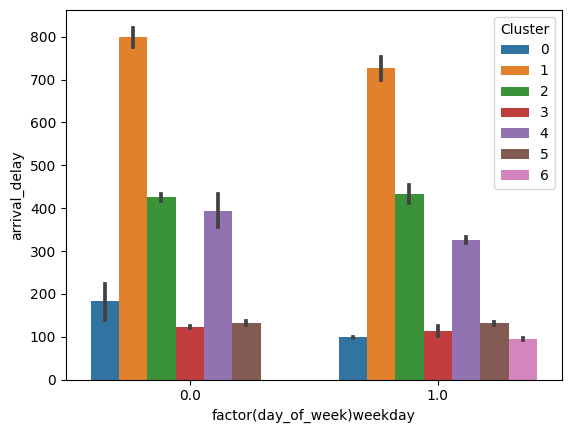

In [77]:
sns.barplot(data=df_test ,x='factor(day_of_week)weekday', y='arrival_delay', hue='Cluster')

<Axes: xlabel='factor(day_of_week)weekday', ylabel='count'>

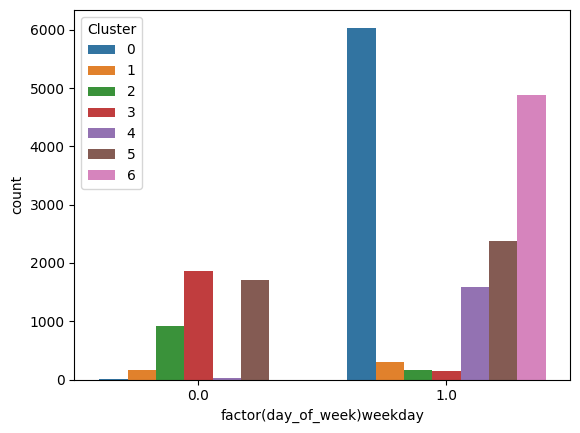

In [78]:
sns.countplot(data=df_test, x='factor(day_of_week)weekday', hue='Cluster')

<Axes: xlabel='factor(time_of_day)Off-peak', ylabel='arrival_delay'>

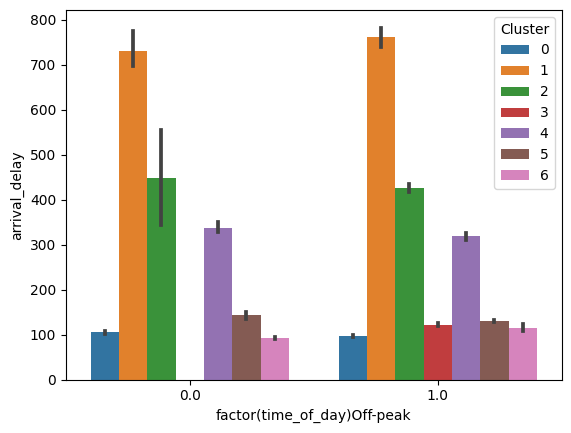

In [79]:
sns.barplot(data=df_test ,x='factor(time_of_day)Off-peak', y='arrival_delay', hue='Cluster')

<Axes: xlabel='factor(time_of_day)Off-peak', ylabel='count'>

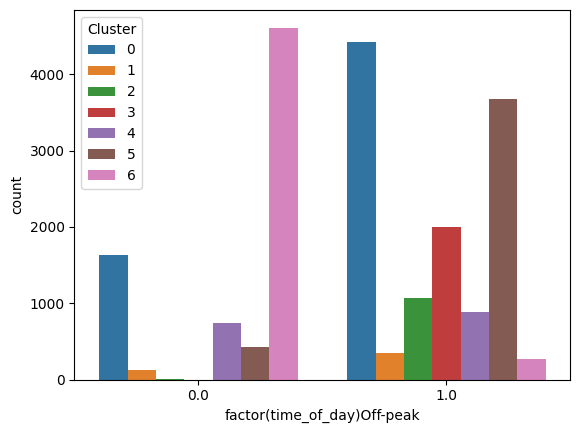

In [80]:
sns.countplot(data=df_test, x='factor(time_of_day)Off-peak', hue='Cluster')

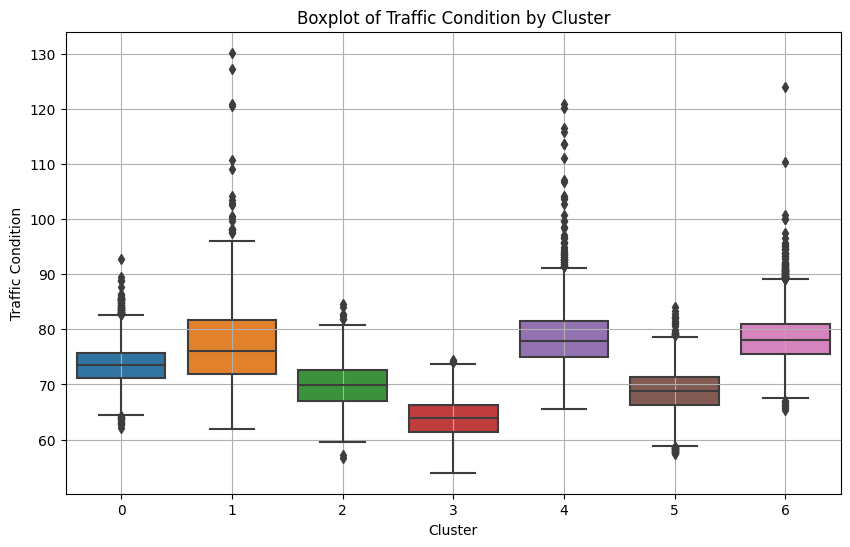

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='Cluster', y='traffic_condition')
plt.title('Boxplot of Traffic Condition by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Traffic Condition')
plt.grid(True)
plt.show()

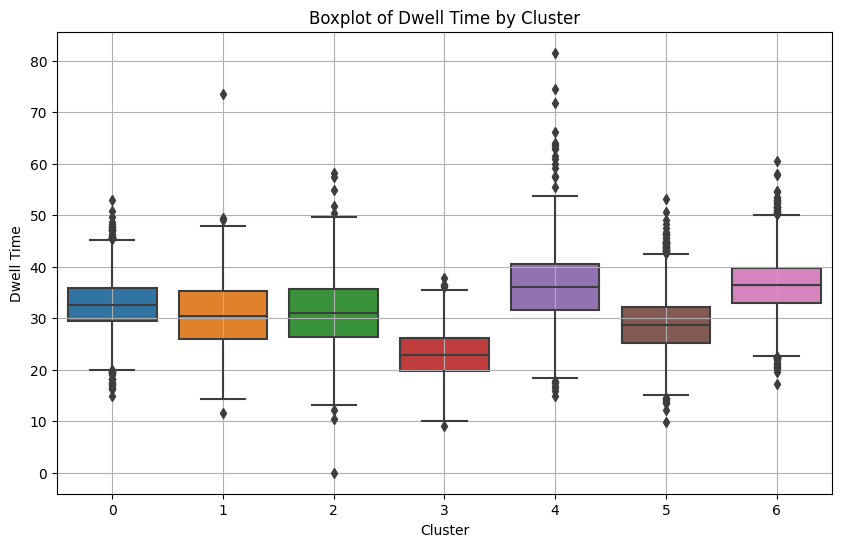

In [82]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='Cluster', y='dwell_time')
plt.title('Boxplot of Dwell Time by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Dwell Time')
plt.grid(True)
plt.show()

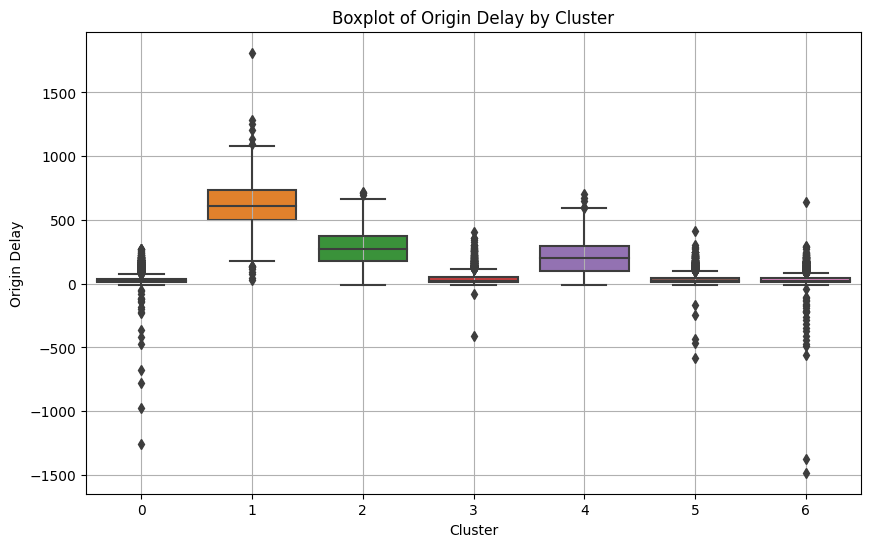

In [83]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='Cluster', y='origin_delay')
plt.title('Boxplot of Origin Delay by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Origin Delay')
plt.grid(True)
plt.show()

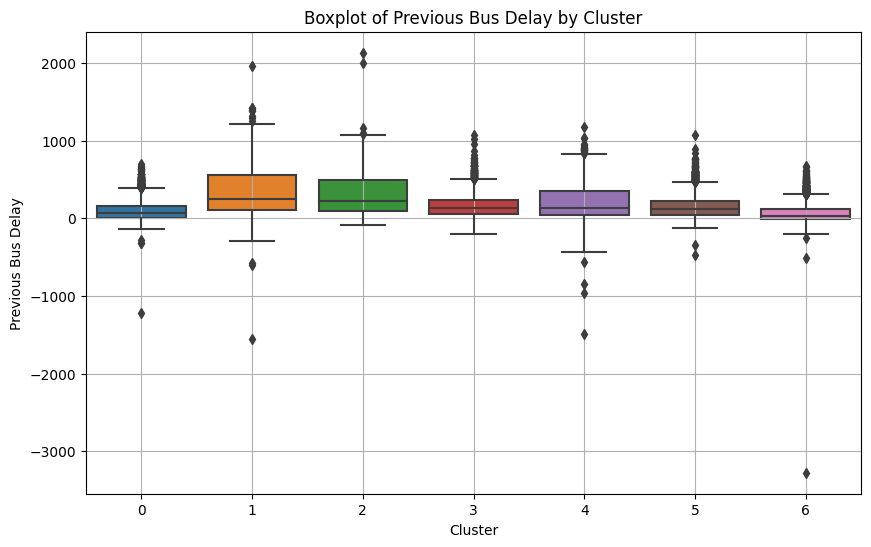

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='Cluster', y='previous_bus_delay')
plt.title('Boxplot of Previous Bus Delay by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Previous Bus Delay')
plt.grid(True)
plt.show()

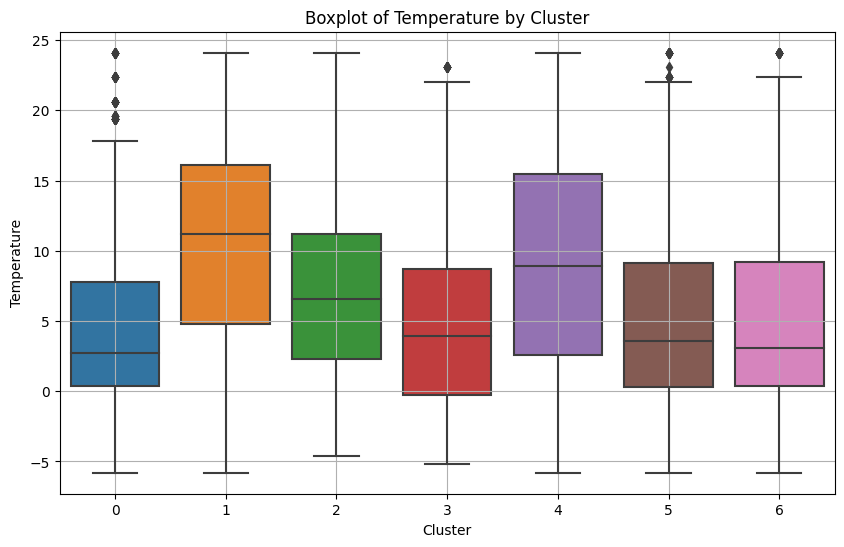

In [85]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='Cluster', y='temp')
plt.title('Boxplot of Temperature by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='Cluster', y='scheduled_travel_time')
plt.title('Boxplot of Scheduled Travel Time by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Scheduled Travel Time')
plt.grid(True)
plt.show()

ValueError: ignored

<Figure size 1000x600 with 0 Axes>

Issue with plot above since there are 89 different values for Scheduled trave time, using:len(pd.unique(df['scheduled_travel_time']))